In [1]:
# Install dependencies
!pip3.9 install --upgrade pip
!pip3.9 install pandas tqdm multiprocess

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
# from tqdm.notebook import tqdm, trange
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import glob

In [3]:
datadir = "./data/*/"
all_datas = sorted(glob.glob(datadir + "*.csv"))

In [4]:
# CSV Count
print("Data CSV Count:", len(all_datas))

Data CSV Count: 42863


In [5]:
from multiprocess import Process, Pool

print("Read files...")

def read(filename):
    name = filename
    
    data = pd.read_csv(filename)
    data["filename"] = name
    # print("Read", filename.split("/")[-1])
    return (name, data)

pool = Pool()
result = list(tqdm(pool.imap(read, all_datas), total=len(all_datas)))

pool.close()
pool.join() # wait till pool to finish calculation

print("Finished Reading files...")

all_df = dict(result)

Read files...


  0%|          | 0/42863 [00:00<?, ?it/s]

Finished Reading files...


In [6]:
# 버스 정류장
busstation1 = "PHB351016075" # 조회할 버스 정류장 - PHB351016075 농협양덕지점 (한동대방향)
busstation2 = "PHB351016076" # 조회할 버스 정류장2 (지나갔을까봐) - PHB351016075 농협양덕지점 (한동대방향)

all_datas = pd.concat(all_df.values(), ignore_index=True) # 모든 데이터를 합친다
all_datas = all_datas[(all_datas.nodeid == busstation1) | (all_datas.nodeid == busstation2)] # 정류장 검색

all_datas.reset_index(inplace=True) # Reset index
all_datas = all_datas[["vehicleno", "nodenm", "filename"]] # vehicle 번호와 filename 만 보여주기
all_datas["time"] = pd.to_datetime(all_datas["filename"], format="%y%m%d/%H%M%S", errors="coerce", exact=False) # filename 에서 시간 계산
all_datas.set_index("time", inplace=True)

all_datas.head()

,vehicleno,nodenm,filename
time,,,
2021-08-24 23:17:03,1377,남광하우스토리,./data/210824/231703.csv
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv
2021-08-25 09:10:03,1431,남광하우스토리,./data/210825/091003.csv
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv
2021-08-25 09:23:03,1383,농협 양덕지점,./data/210825/092303.csv


In [7]:
# 다음 entry 가 같은 vehicleno 일경우 무시
all_datas = all_datas[ 
    all_datas.vehicleno.ne(all_datas.vehicleno.shift())
]
all_datas.head()

,vehicleno,nodenm,filename
time,,,
2021-08-24 23:17:03,1377,남광하우스토리,./data/210824/231703.csv
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv


In [8]:
# 빈파일 목록 확인
empty_files = []
for name, data in all_df.items():
    if len(data) == 0:
        empty_files.append(name)
len(empty_files)

331

In [9]:
# 빈파일들에는 null 데이터를 추가하여 다음 시간이 계산이 안되게 처리.
for file in empty_files:
    datetime = pd.to_datetime(file, format="%y%m%d/%H%M%S", errors="coerce", exact=False)
    all_datas.loc[datetime] = [np.nan for i in range(len(all_datas.columns))]

In [10]:
# 마지막으로 전에 빈 공간이 있을경우 데이터 무시.
all_datas = all_datas.sort_index()
all_datas["diff"] = all_datas.index.to_series().diff()
all_datas = all_datas[~all_datas.vehicleno.shift().isna()].dropna(subset=['filename'])

In [11]:
# 시간 계산
# all_datas["diff"] = all_datas.index.to_series().diff()

In [12]:
# all_datas["diff"]
diff_data = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
goodcond = (diff_data < 120) & (diff_data > 2)
diff_data[goodcond].describe() # 최대시간을 2시간으로 두어 익일인 경우 무시.

count    2303.000000
mean       17.949899
std         6.454143
min         2.966667
25%        14.000000
50%        18.000000
75%        21.033333
max        54.000000
Name: diff, dtype: float64

------
# Visuals

In [13]:
!pip3.9 install matplotlib seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [14]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 한글 폰트 설치
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == "Darwin":
  rc("font", family="AppleGothic")
elif platform.system() == "Windows":
  path="c:/Windows/Font/malgun.ttf"
  font_name = font_manager.FontPropertie(fname=path).get_name()
  rc('font', family=font_name)
else:
  %config InlineBackend.figure_format = 'retina'
  !apt -qq -y install fonts-nanum
  fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
  font = font_manager.FontProperties(fname=fontpath, size=9)
  plt.rc('font', family='NanumBarunGothic')
  font_manager._rebuild()

In [16]:
vis = pd.DataFrame(all_datas)
vis['dval'] = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
vis = vis[(goodcond)]
vis.head()

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv,0 days 00:13:00,13.000000
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv,0 days 00:17:00,17.000000
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv,0 days 00:22:01,22.016667
2021-08-25 10:18:03,1348,농협 양덕지점,./data/210825/101803.csv,0 days 00:17:00,17.000000
2021-08-25 10:39:02,1428,농협 양덕지점,./data/210825/103902.csv,0 days 00:20:59,20.983333


In [17]:
vis['hour'] = vis.index.hour
hourdata = vis.groupby(by="hour").mean()
hourdata

,dval
hour,
9,16.725581
10,19.148397
11,18.235669
12,17.556481
13,17.466193
14,18.385889
15,18.570078
16,18.457260
17,19.254565


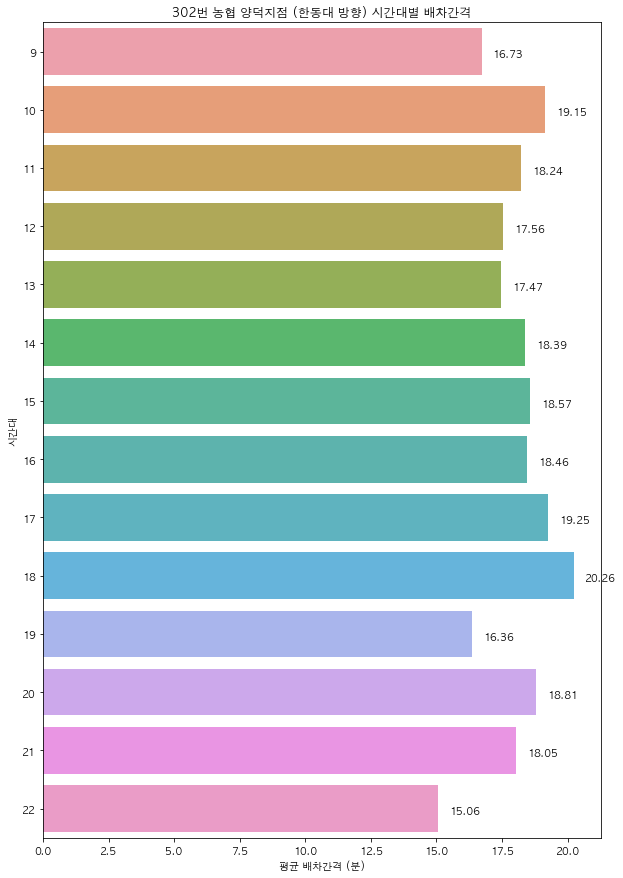

In [18]:
%matplotlib inline

# 그래프 준비
plt.figure(figsize=(10,15))
# hourdata.dtypes
# plt.barh(hourdata.index.astype(str), hourdata['dval'])

barg = sns.barplot(x=hourdata['dval'], y=hourdata.index.astype(str), alpha=0.9, orient='h')

# Label 추가
for p in barg.patches:
    width = p.get_width()
    plt.text(1+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title("302번 농협 양덕지점 (한동대 방향) 시간대별 배차간격")
plt.xlabel("평균 배차간격 (분)")
plt.ylabel("시간대")

plt.show()



In [19]:
vis['hour'] = vis.index.hour
hourdataMid = vis.groupby(by="hour").median()
hourdataMid

,dval
hour,
9,16.966667
10,19.000000
11,18.016667
12,17.500000
13,17.000000
14,18.000000
15,18.016667
16,19.000000
17,19.000000


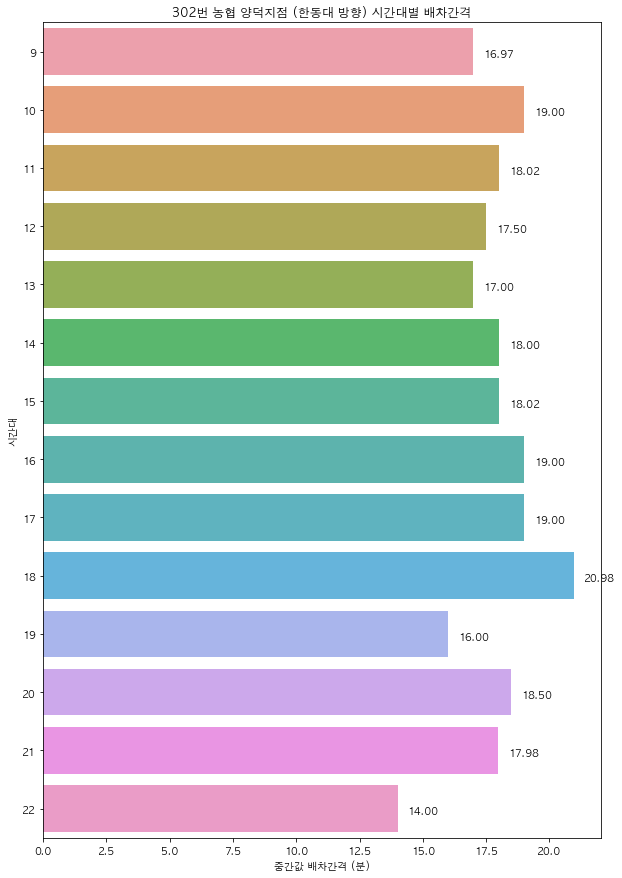

In [20]:
# 그래프 준비
plt.figure(figsize=(10,15))
# hourdata.dtypes
# plt.barh(hourdata.index.astype(str), hourdata['dval'])

barg = sns.barplot(x=hourdataMid['dval'], y=hourdataMid.index.astype(str), alpha=0.9, orient='h')

# Label 추가
for p in barg.patches:
    width = p.get_width()
    plt.text(1+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title("302번 농협 양덕지점 (한동대 방향) 시간대별 배차간격")
plt.xlabel("중간값 배차간격 (분)")
plt.ylabel("시간대")

plt.show()

------------

# Test Process

In [21]:
copy = pd.DataFrame(all_datas)
copy.head()

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv,0 days 09:51:59,591.983333
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv,0 days 00:13:00,13.000000
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv,0 days 00:17:00,17.000000
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv,0 days 00:22:01,22.016667
2021-08-25 10:18:03,1348,농협 양덕지점,./data/210825/101803.csv,0 days 00:17:00,17.000000


In [22]:
copy.dropna(subset=["diff"], inplace=True)
copy['dval'] = all_datas.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
copy.head()

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv,0 days 09:51:59,591.983333
2021-08-25 09:22:02,1383,농협 양덕지점,./data/210825/092202.csv,0 days 00:13:00,13.000000
2021-08-25 09:39:02,1323,농협 양덕지점,./data/210825/093902.csv,0 days 00:17:00,17.000000
2021-08-25 10:01:03,1349,농협 양덕지점,./data/210825/100103.csv,0 days 00:22:01,22.016667
2021-08-25 10:18:03,1348,농협 양덕지점,./data/210825/101803.csv,0 days 00:17:00,17.000000


In [23]:
copy.loc[copy['dval'] > 70].sort_values(by=["dval"]).head()

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 09:09:02,1431,남광하우스토리,./data/210825/090902.csv,0 days 09:51:59,591.983333
2021-09-18 09:00:04,1236,농협 양덕지점,./data/210918/090004.csv,0 days 10:01:01,601.016667
2021-09-07 09:02:03,1323,농협 양덕지점,./data/210907/090203.csv,0 days 10:03:01,603.016667
2021-09-04 09:03:03,1346,농협 양덕지점,./data/210904/090303.csv,0 days 10:04:00,604.000000
2021-09-06 09:00:03,1349,남광하우스토리,./data/210906/090003.csv,0 days 10:04:00,604.000000


In [24]:
copy.loc[copy['dval'] == 0]

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-08-25 19:13:03,1348,남광하우스토리,./data/210825/191303.csv,0 days,0.0
2021-08-25 19:14:03,1348,남광하우스토리,./data/210825/191403.csv,0 days,0.0
2021-08-30 21:02:03,1236,농협 양덕지점,./data/210830/210203.csv,0 days,0.0
2021-08-30 21:03:03,1377,남광하우스토리,./data/210830/210303.csv,0 days,0.0
2021-08-31 17:35:03,1338,남광하우스토리,./data/210831/173503.csv,0 days,0.0
...,...,...,...,...,...
2021-10-21 19:03:03,1429,농협 양덕지점,./data/211021/190303.csv,0 days,0.0
2021-10-21 19:04:03,1429,남광하우스토리,./data/211021/190403.csv,0 days,0.0
2021-10-21 19:05:03,1429,남광하우스토리,./data/211021/190503.csv,0 days,0.0


In [25]:
# all Days
print("Number of days:", len(copy.groupby(pd.Grouper(freq='D'))))

Number of days: 59


In [26]:
copy.sort_values(['time', 'vehicleno']).loc["2021-10-18"]

,vehicleno,nodenm,filename,diff,dval
time,,,,,
2021-10-18 09:05:03,1261,농협 양덕지점,./data/211018/090503.csv,0 days 10:16:00,616.000000
2021-10-18 09:17:03,1382,농협 양덕지점,./data/211018/091703.csv,0 days 00:12:00,12.000000
2021-10-18 09:22:03,1382,남광하우스토리,./data/211018/092203.csv,0 days 00:05:00,5.000000
2021-10-18 09:22:03,1429,농협 양덕지점,./data/211018/092203.csv,0 days 00:00:00,0.000000
2021-10-18 09:23:03,1382,남광하우스토리,./data/211018/092303.csv,0 days 00:00:00,0.000000
2021-10-18 09:23:03,1429,농협 양덕지점,./data/211018/092303.csv,0 days 00:01:00,1.000000
2021-10-18 09:24:02,1429,농협 양덕지점,./data/211018/092402.csv,0 days 00:00:59,0.983333
2021-10-18 09:50:02,1239,농협 양덕지점,./data/211018/095002.csv,0 days 00:26:00,26.000000
2021-10-18 09:57:03,1431,농협 양덕지점,./data/211018/095703.csv,0 days 00:07:01,7.016667


In [27]:
# 빈파일 목록 확인
empty_files = []
for name, data in all_df.items():
    if len(data) == 0:
        empty_files.append(name)
len(empty_files)

331

In [28]:
import numpy as np
# 빈파일들에는 null 데이터를 추가하여 다음 시간이 계산이 안되게 처리.
for file in empty_files:
    datetime = pd.to_datetime(file, format="%y%m%d/%H%M%S", errors="coerce", exact=False)
    copy.loc[datetime] = [np.nan for i in range(len(copy.columns))]

In [29]:
copyr = copy.sort_index()
copyr["diff2"] = copyr.index.to_series().diff()
copyr = copyr[~copyr.vehicleno.shift().isna()].dropna(subset=['filename'])
print(len(copyr))
# copyr.loc['2021-09-14 13:30':'2021-09-14 16:30']

2529


In [30]:
# all_datas["diff"]
copyr_diffdata = copyr.dropna(subset=["diff"])["diff"].dt.seconds.div(60, fill_value=0)
copyr_diffdata[(copyr_diffdata < 120) & (copyr_diffdata > 2)].describe() # 최대시간을 2시간으로 두어 익일인 경우 무시.

count    2297.000000
mean       17.946728
std         6.456012
min         2.966667
25%        14.000000
50%        18.000000
75%        21.016667
max        54.000000
Name: diff, dtype: float64

In [31]:
# Remove diff data if last row doesn't have any information
for item in copyr.index:
    print(copyr.vehicleno.shift().loc[item])
    if pd.isnull(copyr.vehicleno.shift().loc[item]):
        copyr.loc[item, "dval"] = np.nan

nan
1383
1323
1349
1348
1428
1346
1377
1236
1338
1239
1343
1261
1382
1429
1405
1383
1229
1349
1348
1428
1346
1377
1236
1338
1239
1343
1261
1382
1429
1431
1383
1323
1349
time
2021-08-25 19:13:03    1348
2021-08-25 19:13:03    1428
Name: vehicleno, dtype: object


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
copyr.diff2

In [ ]:
copy

In [ ]:
copy.sort_index().loc['2021-09-14 13:30':'2021-09-14 16:30']

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
copy.sort_index().loc['2021-09-14']

In [ ]:
# Filter all empty files
len(result)

In [ ]:
# https://stackoverflow.com/questions/56057755/extract-all-rows-in-dataframe-having-same-date
for name, group in copy.groupby(pd.Grouper(freq='D')):
    print(name)